# Minimum Weight Perfect Matching

Here we will impelement the Minimum Weight Perfect Matching decoder for the surface code with a depolarizing noise model.

In [32]:
from typing import Tuple, Dict, List
import itertools
import re
from math import log
import numpy as np
import networkx as nx

In [33]:
class ErrorModel:
    """This class encodes an uncorrelated error model with different probabilities of X, Y, and Z errors."""

    def __init__(self, model_dict: Dict[int, Tuple[float, float, float]]):
        """The error model can be represented by a dictionary mapping qubit indices,
        which are integers, to a tuple of three floats, those being the probabilities
        of X, Y, and Z errors."""

        self._dict = model_dict
    
    @property
    def nqubits(self):
        return len(self._dict.keys())
    
    def uniform(nqubits: int, px: float, py: float, pz: float):
        """A model where every qubit has the same error probabilities."""

        assert px >= 0
        assert py >= 0
        assert pz >= 0
        assert px + py + pz <= 1.0, "Probabilites of X, Y, and Z errors cannot be greater than 1."
        
        dict = {q: (px, py, pz) for q in range(nqubits)}
        return ErrorModel(dict)

    def depolarizing(nqubits: int, lamb: float):
        """A uniform depolarizing model on each qubit."""

        return ErrorModel.uniform(nqubits, lamb / 3., lamb / 3., lamb / 3.)
    
    def prob(self, i: int, pauli: str):
        """Probability of X, Y, or Z error.  Possible inputs are 'X', 'Y', 'Z', 'X or Y', or 'Y or Z'."""

        assert i in range(self.nqubits)

        if pauli == 'X':
            return self._dict[i][0]
        elif pauli == 'Y':
            return self._dict[i][1]
        elif pauli == 'Z':
            return self._dict[i][2]
        elif pauli == 'Y or Z':
            return self._dict[i][1] + self._dict[i][2]
        elif pauli == 'X or Y':
            return self._dict[i][0] + self._dict[i][1]
        else:
            raise ValueError(f"Unrecognized argument for Pauli: '{pauli}'.")

In [34]:
error_model = ErrorModel.uniform(10, 0.1, 0.2, 0.1)

In [35]:
def surface_code_tanner_graphs(d: int) -> Tuple[nx.Graph, nx.Graph]:
    """Get the X and Z check Tanner graphs for the rotated surface code."""

    x_graph = nx.Graph()
    z_graph = nx.Graph()
    # For the data qubits, we number them first by rows, then by columns. E.g. for d=3
    # 0 1 2
    # 3 4 5
    # 6 7 8
    # For measure qubits, we first number the "inner" 4-body chekcs.
    # Then we number the top, bottom, left, and right checks, e.g.
    # * * 4 *
    # 6 0 1 *
    # * 2 3 7
    # * 5 * *
    # where * denotes that there is no check there. On this chart, checks
    # 4, 0, 3, and 5 are all X checks, and checks 6, 1, 2, and 7 are Z checks.
    # Add nodes for the data qubits.
    for i in range(d ** 2):
        x_graph.add_node(f"q{i}")
        z_graph.add_node(f"q{i}")
    # Add nodes for the check qubits.
    num_checks = (d - 1) ** 2 + 2 * (d - 1) # Number of checks for both X or Z
    for i in range(num_checks):
        x_graph.add_node(f"s{i}")
        z_graph.add_node(f"s{i}")
    
    # Four-body checks.
    for i in range(d - 1): # Rows of the lattice of plaquettes
        if i % 2 == 0:
            is_x_check = True
        else:
            is_x_check = False
        for j in range(d - 1): # Columns of the lattice of plaquettes
            stabilizer = f"s{i * (d-1) + j}"
            if is_x_check:
                x_graph.add_edge(f"q{i * d + j}", stabilizer)
                x_graph.add_edge(f"q{i * d + j + 1}", stabilizer)
                x_graph.add_edge(f"q{(i + 1) * d + j}", stabilizer)
                x_graph.add_edge(f"q{(i + 1) * d + j + 1}", stabilizer)
            else:
                z_graph.add_edge(f"q{i * d + j}", stabilizer)
                z_graph.add_edge(f"q{i * d + j + 1}", stabilizer)
                z_graph.add_edge(f"q{(i + 1) * d + j}", stabilizer)
                z_graph.add_edge(f"q{(i + 1) * d + j + 1}", stabilizer)
            is_x_check = not is_x_check
    
    k = (d - 1) ** 2 # Index of two-body check.
    if d % 2 == 0:
        two_body_checks_per_side = d // 2
    else:
        two_body_checks_per_side = (d - 1) // 2
    # X checks at the top of the lattice
    i = 0 # Data qubit row index
    j = 1 # Data qubit column index
    for _ in range(two_body_checks_per_side):
        x_graph.add_edge(f"q{i * d + j}", f"s{k}")
        x_graph.add_edge(f"q{i * d + j + 1}", f"s{k}")
        k += 1
        j += 2
    # X checks at the bottom of the lattice
    i = d - 1 # Data qubit column index
    j = 0 # Data qubit row index
    for _ in range(two_body_checks_per_side):
        x_graph.add_edge(f"q{i * d + j}", f"s{k}")
        x_graph.add_edge(f"q{i * d + j + 1}", f"s{k}")
        k += 1
        j += 2
    # Z checks to the left of the lattice
    i = 0 # Data qubit column index
    j = 0 # Data qubit row index
    for _ in range(two_body_checks_per_side):
        z_graph.add_edge(f"q{i * d + j}", f"s{k}")
        z_graph.add_edge(f"q{(i + 1) * d + j}", f"s{k}")
        k += 1
        i += 2
    # Z checks to the right of the lattice
    i = 1 # Data qubit column index
    j = d - 1 # Data qubit row index
    for _ in range(two_body_checks_per_side):
        z_graph.add_edge(f"q{i * d + j}", f"s{k}")
        z_graph.add_edge(f"q{(i + 1) * d + j}", f"s{k}")
        k += 1
        i += 2

    # Some stabilizers are not involved in the X or Z graphs.
    # Remove them.
    x_graph.remove_nodes_from(list(nx.isolates(x_graph)))
    z_graph.remove_nodes_from(list(nx.isolates(z_graph)))
    return (x_graph, z_graph)

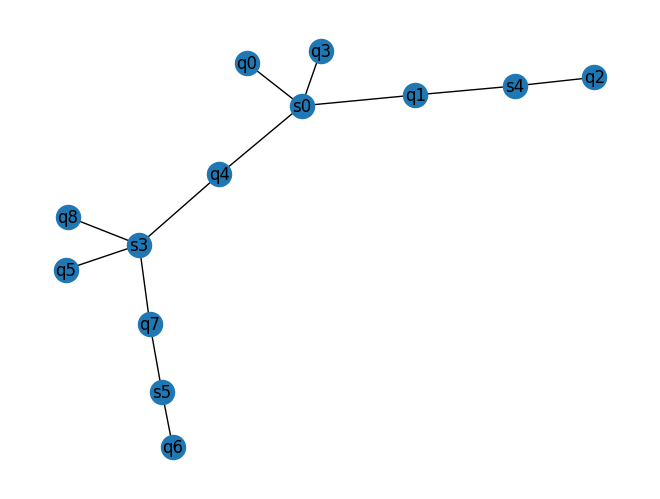

In [36]:
d = 3
x_graph, z_graph = surface_code_tanner_graphs(d)
nx.draw(x_graph, with_labels=True)

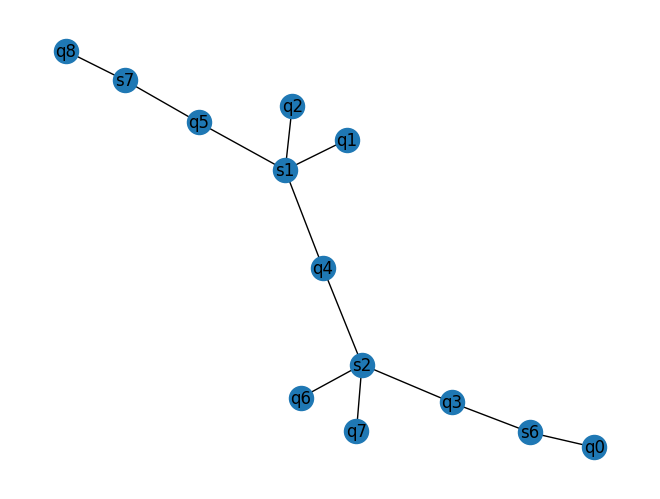

In [37]:
nx.draw(z_graph, with_labels=True)

In [38]:
def error_to_syndrome(err: np.ndarray, graph: nx.Graph) -> List[str]:
    """Map an error (either the X or Z part of a binary symplectic vector) to a syndrome
    (represented as a map from syndrome node names on the Tanner graph to booleans)."""

    syndrome_nodes = [n for n in graph.nodes if 's' in n]
    syndrome: List[str] = []
    for s in syndrome_nodes:
        num_neighbors_true = 0
        for nn in graph.neighbors(s):
            idx = int(re.search(r'\d+', nn).group()) 
            if err[idx]:
                num_neighbors_true += 1
        if num_neighbors_true % 2 != 0:
            syndrome.append(s)
    return syndrome

In [39]:
for i in range(d ** 2):
    err = np.zeros(d ** 2, dtype=bool)
    err[i] = True
    syndrome = error_to_syndrome(err, x_graph)
    print(i, syndrome)

0 ['s0']
1 ['s0', 's4']
2 ['s4']
3 ['s0']
4 ['s0', 's3']
5 ['s3']
6 ['s5']
7 ['s3', 's5']
8 ['s3']


In [40]:
for i in range(d ** 2):
    err = np.zeros(d ** 2, dtype=bool)
    err[i] = True
    syndrome = error_to_syndrome(err, z_graph)
    print(i, syndrome)

0 ['s6']
1 ['s1']
2 ['s1']
3 ['s2', 's6']
4 ['s1', 's2']
5 ['s1', 's7']
6 ['s2']
7 ['s2']
8 ['s7']


In [41]:
def matching_graph(error_model: ErrorModel, tanner_graph: nx.Graph, mode: str) -> nx.Graph:
    """Get the matching graph for either X or Z errors.
    
    Arguments:
    error_model - An instance of ErrorModel.
    tanner_graph - The graph corresponding to either X or Z checks.
    mode - A string, either 'X' or 'Z' to indicate which probabilities we should draw
    from the error model. N.b. pass 'Z' for the X-check Tanner graph and 'X' for Z-check graph.
    
    Returns:
    matching_graph - Matching graph for this code and error model."""

    qubit_nodes = [n for n in tanner_graph.nodes if 'q' in n]
    syndrome_nodes = [n for n in tanner_graph.nodes if 's' in n]
    assert len(qubit_nodes) + len(syndrome_nodes) == len(tanner_graph.nodes)

    match_graph = nx.Graph()
    for s in syndrome_nodes:
        match_graph.add_node(s)
    # Add an edge for each qubits.
    extra_node_idx = 0 # Index of nodes added when a qubit only has one check operator.
    extra_nodes: List[str] = []
    for qn in qubit_nodes:
        idx = int(re.search(r'\d+', qn).group()) 
        if mode == 'Z':
            p = error_model.prob(idx, 'Y or Z')
        else:
            p = error_model.prob(idx, 'X or Y')
        w = log((1. - p) / p)
        neighbor_syndromes = list(tanner_graph.neighbors(qn))
        if len(neighbor_syndromes) == 2:
            match_graph.add_edge(neighbor_syndromes[0], neighbor_syndromes[1], weight=w)
        elif len(neighbor_syndromes) == 1:
            # We need to create an extra node.
            node_name = f"e{extra_node_idx}"
            extra_nodes.append(node_name)
            match_graph.add_node(node_name)
            match_graph.add_edge(neighbor_syndromes[0], node_name, weight=w)
            extra_node_idx += 1
        else:
            raise ValueError(f"Node {qn} has {len(neighbor_syndromes)} neighbors, should have 1 or 2.")
    
    # Connect the extra nodes together:
    if len(extra_nodes) > 1:
        for i in range(0, len(extra_nodes)):
            if i != len(extra_nodes) - 1:
                match_graph.add_edge(f"e{i}", f"e{i+1}", weight=0.)
            else:
                match_graph.add_edge("e0", f"e{i}", weight=0.)
    return match_graph

In [42]:
def matching_graph_to_syndrome_graph(match_graph: nx.Graph, syndrome: List[str]) -> nx.Graph:
    """Form the syndrome graph from a matching graph and a syndrome. A node in the matching
    graph is also a a node in the syndrome graph only if that bit is True in the syndrome
    (i.e. it is present in the list of nodes that we pass)."""

    syndrome_graph = nx.Graph()
    for s in syndrome:
        syndrome_graph.add_node(s)
    
    for s1 in syndrome_graph.nodes:
        for s2 in syndrome_graph.nodes:
            if s1 != s2:
                length = nx.shortest_path_length(match_graph, s1, s2, weight='weight')
                syndrome_graph.add_edge(s1, s2, weight=length)
    return syndrome_graph

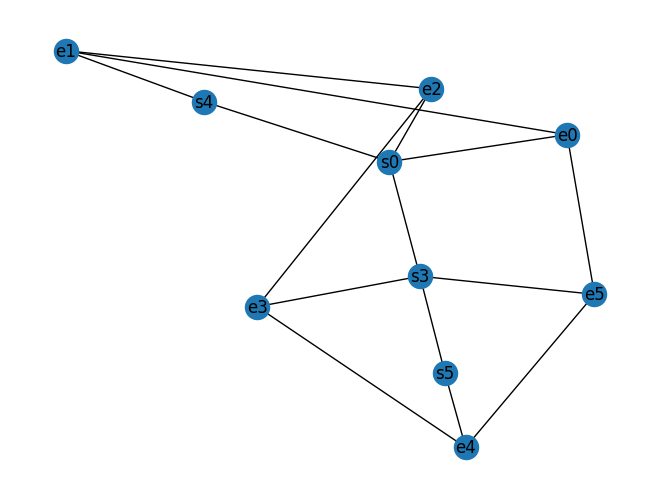

In [43]:
error_model = ErrorModel.uniform(d ** 2, 0., 0., 0.2)
match_graph = matching_graph(error_model, x_graph, 'Z')
nx.draw(match_graph, with_labels=True)

['s0', 's3', 's5']


{('s0',
  's3'): Text(-0.24626358321741648, 0.3512492522428876, '1.3862943611198906'),
 ('s0',
  's5'): Text(-0.15609732001613996, -0.4999999118223635, '2.772588722239781'),
 ('s3',
  's5'): Text(0.40236178251189014, 0.14874651911500525, '1.3862943611198906')}

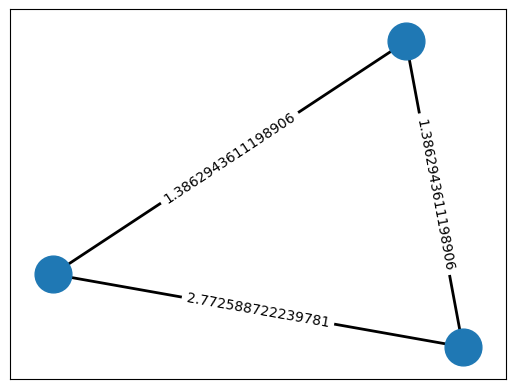

In [44]:
# Syndrome graph for a Z error
err = np.zeros(25, dtype=bool)
err[0] = True
err[7] = True
syndrome = error_to_syndrome(err, x_graph)
print(syndrome)
syndrome_graph = matching_graph_to_syndrome_graph(match_graph, syndrome)
edge_labels = nx.get_edge_attributes(syndrome_graph, "weight")
pos = nx.spring_layout(syndrome_graph, seed=7)
nx.draw_networkx_nodes(syndrome_graph, pos, node_size=700)
nx.draw_networkx_edges(syndrome_graph, pos, width=2)
nx.draw_networkx_edge_labels(syndrome_graph, pos, edge_labels)

In [45]:
matching = nx.min_weight_matching(syndrome_graph)
print(type(matching))
print(matching)

<class 'set'>
{('s5', 's3')}


In [46]:
nodes = list(syndrome_graph.nodes)
dir(nodes[0])
print(str(nodes[0]))

s0


In [47]:
def syndrome_path_to_qubits(tanner_graph: nx.Graph, syndromes: List[str]) -> List[str]:
    """Given a pair of syndromes and a Tanner graph, find the qubit that flipped."""

    def sptq_syndrome_pair_to_qubit(s1, s2):
        # Find the qubit that has the two syndromes in common.
        s1_qubits = set(tanner_graph.neighbors(s1))
        s2_qubits = set(tanner_graph.neighbors(s2))
        intersection = s1_qubits.intersection(s2_qubits)
        if len(intersection) == 1:
            return list(intersection)[0]
        else:
            raise ValueError(f"Syndromes {s1} and {s2} have {len(intersection)} qubits in common.")
    
    qubits = []
    for i in range(len(syndromes) - 1):
        qubits.append(sptq_syndrome_pair_to_qubit(syndromes[i], syndromes[i+1]))
    return qubits


def matching_to_correction(tanner_graph: nx.Graph, match_graph: nx.Graph, syndrome_graph: nx.Graph, matching: set) -> np.ndarray:
    """Map a matching to a correction by finding the shortest paths between syndromes on the graph.
    Each path represents a chain of errors, since each edge on the matching graph is a qubit error."""

    nodes_in_syndrome = set([str(n) for n in syndrome_graph.nodes])

    # Find a shortest path on the matching graph for each pair of nodes in the matching.
    paths = []
    for s1, s2 in matching:
        paths.append(nx.shortest_path(match_graph, s1, s2))
        nodes_in_syndrome.remove(s1)
        nodes_in_syndrome.remove(s2)
    
    print("Paths found:")
    for path in paths:
        print(path)
    
    qubits = [syndrome_path_to_qubits(tanner_graph, s) for s in paths]
    return itertools.chain(*qubits)

In [48]:
error_qubits = matching_to_correction(x_graph, match_graph, syndrome_graph, matching)
for q in error_qubits:
    print(q)

Paths found:
['s5', 's3']
q7
